In [1]:
import osmnx as ox
import networkx as nx
import geopandas as gpd

import folium
import random
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from shapely.geometry import Point, LineString, mapping
from ipyleaflet import Map, Polyline, Marker
import warnings
warnings.filterwarnings("ignore")

In [2]:
! pip install -q ipyleaflet

In [3]:
north, south, east, west = 39.97, 39.84, 116.46, 116.30
bbox = (north, south, east, west)
# Create graph
G = ox.graph_from_bbox(bbox[1], bbox[0], bbox[3], bbox[2], network_type='all')

(<Figure size 800x800 with 1 Axes>, <Axes: >)

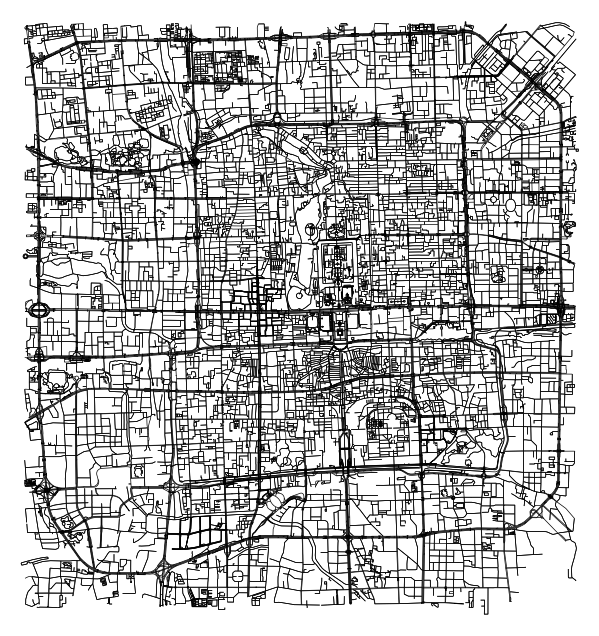

In [4]:
ox.plot_graph(G, show=False, close=False, bgcolor='white', node_color='w', node_size=0, edge_color='k', edge_linewidth=0.5)

In [5]:
gdf_nodes, gdf_edges = ox.graph_to_gdfs(G)
gdf_nodes.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 26111 entries, 25585055 to 11711358682
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   y             26111 non-null  float64 
 1   x             26111 non-null  float64 
 2   street_count  26111 non-null  int64   
 3   highway       3112 non-null   object  
 4   ref           158 non-null    object  
 5   geometry      26111 non-null  geometry
dtypes: float64(2), geometry(1), int64(1), object(2)
memory usage: 1.4+ MB


In [6]:
gdf_edges.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
MultiIndex: 64164 entries, (25585055, 5098449244, 0) to (11711358682, 1015656848, 0)
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   osmid     64164 non-null  object  
 1   name      21476 non-null  object  
 2   highway   64164 non-null  object  
 3   oneway    64164 non-null  object  
 4   reversed  64164 non-null  object  
 5   length    64164 non-null  float64 
 6   geometry  64164 non-null  geometry
 7   service   5376 non-null   object  
 8   bridge    2948 non-null   object  
 9   ref       348 non-null    object  
 10  lanes     1218 non-null   object  
 11  tunnel    1083 non-null   object  
 12  maxspeed  302 non-null    object  
 13  access    406 non-null    object  
 14  junction  58 non-null     object  
 15  width     22 non-null     object  
dtypes: float64(1), geometry(1), object(14)
memory usage: 10.6+ MB


In [7]:
node_stats = gdf_nodes.describe()
print(node_stats)

                  y             x  street_count
count  26111.000000  26111.000000  26111.000000
mean      39.910135    116.380729      2.971162
std        0.033895      0.042759      0.941476
min       39.840004    116.300016      1.000000
25%       39.884426    116.348678      3.000000
50%       39.909784    116.382404      3.000000
75%       39.937437    116.414847      4.000000
max       39.969999    116.459993     10.000000


In [8]:
edge_stats = gdf_edges.describe()
print(edge_stats)

             length
count  64164.000000
mean      87.036531
std      109.317123
min        0.284000
25%       16.988000
50%       53.020000
75%      116.740000
max     3706.540000


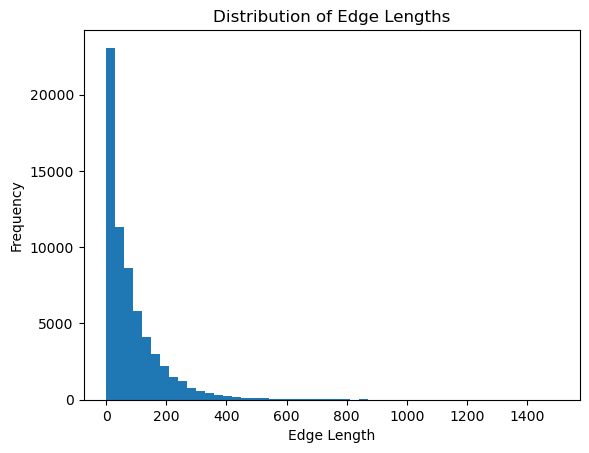

In [28]:
# Distribution of edge lengths
plt.hist(gdf_edges['length'], bins=50, range=(0, 1500))
plt.xlabel('Edge Length')
plt.ylabel('Frequency')
plt.title('Distribution of Edge Lengths')
plt.show()

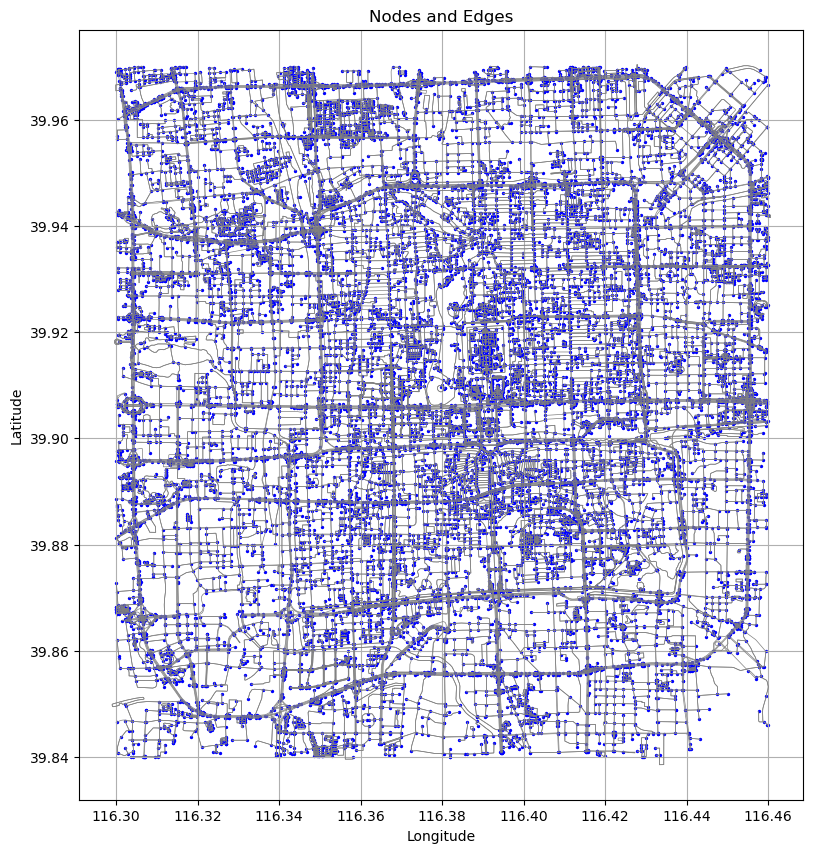

In [10]:
plt.figure(figsize=(10, 10))

gdf_nodes.plot(ax=plt.gca(), color='blue', markersize=2)
gdf_edges.plot(ax=plt.gca(), color='gray', linewidth=0.5)

plt.title('Nodes and Edges')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()

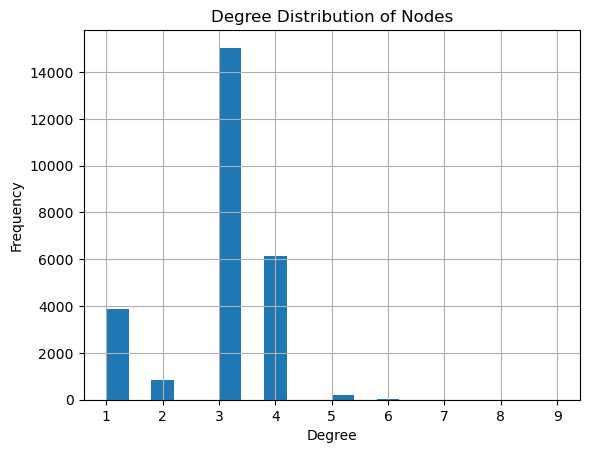

In [11]:
node_degree = nx.degree(nx.Graph(G))

# Plot degree distribution
plt.hist(dict(node_degree).values(), bins=20)
plt.title('Degree Distribution of Nodes')
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [12]:
tags = {
    'amenity': ['restaurant', 'hospital', 'school', 'bar', 'fast_food', 'police', 'library', 'university', 'bank'],
    'building': ['hotel', 'apartments','residential', 'house', 'commercial', 'office', 'industrial']
}

# Retrieve features within the bounding box based on the specified tags
features = ox.geometries.geometries_from_bbox(bbox[1], bbox[0], bbox[3], bbox[2], tags=tags)

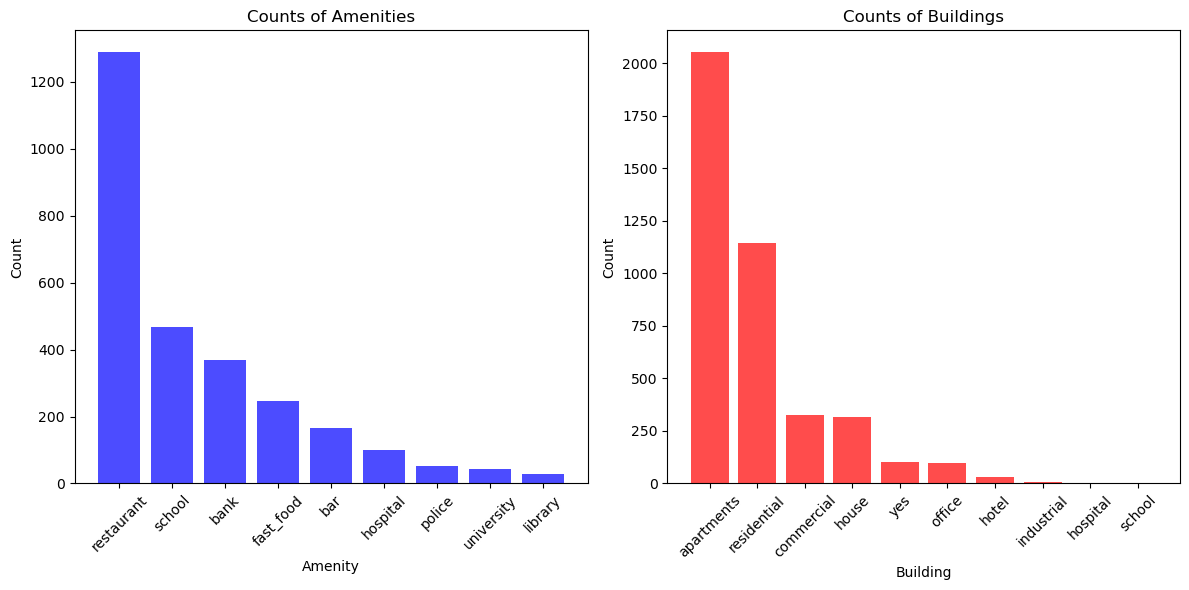

In [13]:
amenity_counts = features['amenity'].value_counts()
building_counts = features['building'].value_counts()

# Create separate plots for amenities and buildings
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot counts for amenities
axes[0].bar(amenity_counts.index, amenity_counts.values, color='blue', alpha=0.7)
axes[0].set_title('Counts of Amenities')
axes[0].set_xlabel('Amenity')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=45)

# Plot counts for buildings
axes[1].bar(building_counts.index, building_counts.values, color='red', alpha=0.7)
axes[1].set_title('Counts of Buildings')
axes[1].set_xlabel('Building')
axes[1].set_ylabel('Count')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

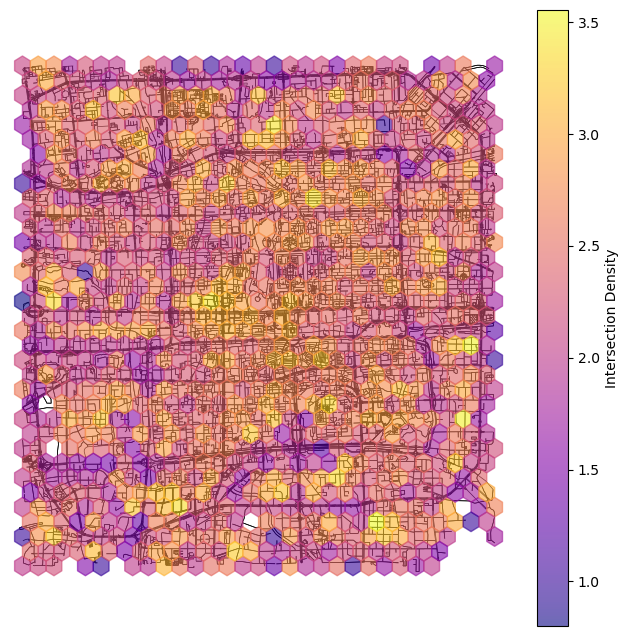

In [14]:
intersection_density = []
for node in G.nodes(data=True):
    count = sum(1 for neighbor in G.neighbors(node[0]))
    intersection_density.append(count)

gdf_nodes['intersection_density'] = intersection_density
fig, ax = ox.plot_graph(G, show=False, close=False, bgcolor='white', node_color='w', node_size=0, edge_color='k', edge_linewidth=0.5)
hb = ax.hexbin(gdf_nodes['x'], gdf_nodes['y'], gridsize=30, cmap='plasma', C=gdf_nodes['intersection_density'], alpha=0.6)
cb = fig.colorbar(hb, ax=ax)
cb.set_label('Intersection Density')

plt.show()

In [15]:
# Get a list of nodes in the graph
nodes = list(G.nodes()
# Choose source and target nodes randomly
source_node = random.choice(nodes)
target_node = random.choice(nodes)

print("Randomly Chosen Source Node ID:", source_node)
print("Randomly Chosen Target Node ID:", target_node)

Randomly Chosen Source Node ID: 8829266504
Randomly Chosen Target Node ID: 10676885630


In [16]:
shortest_path = nx.shortest_path(G, source=source_node, target=target_node, weight='length')
print("Shortest Path:", shortest_path)

Shortest Path: [8829266504, 6013088341, 6013087721, 6013086017, 6013089376, 6013089098, 4713696526, 6009694227, 6009694938, 6009694215, 6009694226, 1687056659, 6650358681, 6650358678, 5300284255, 9296257998, 9296257994, 9296257995, 9385334227, 9296257999, 3071645955, 3071645957, 533652025, 8835880546, 8835880547, 733967370, 733967376, 330840058, 8835880556, 8835880557, 342821095, 1583230856, 733967206, 9671452040, 9671452047, 9671463065, 9671455189, 1300406485, 9296266514, 9296266511, 9296278329, 9296278320, 9296278321, 9296278336, 9296278345, 9296278346, 9296278347, 9296278341, 2010523651, 2327213140, 11380974104, 11524223764, 11380974110, 3033988821, 11380974109, 11380974090, 11524248279, 11524248278, 10676859058, 10676885620, 11524248270, 10676885625, 10676885631, 10676885630]


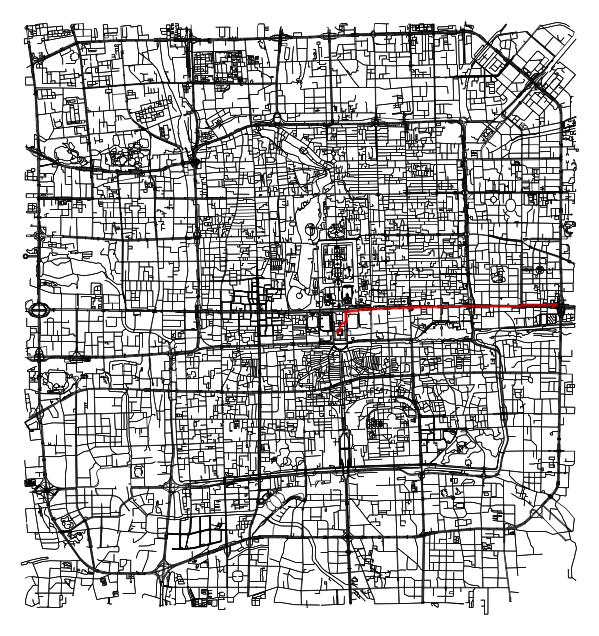

In [17]:
fig, ax = ox.plot_graph(G, show=False, close=False, bgcolor='white', node_color='w', node_size=0, edge_color='k', edge_linewidth=0.5)
# Extract coordinates of the nodes in the shortest path
path_coords = gdf_nodes.loc[shortest_path, 'geometry'].apply(lambda x: (x.x, x.y))
# Unpack the coordinates
x, y = zip(*path_coords)
ax.plot(x, y, color='red', linewidth=2, alpha=0.7)
plt.show()


In [18]:
# Convert NetworkX graph to GeoDataFrame
gdf_nodes, gdf_edges = ox.graph_to_gdfs(G)

# Create GeoDataFrame for nodes and edges
nodes_gdf = gpd.GeoDataFrame(gdf_nodes, geometry=gdf_nodes['geometry'])
edges_gdf = gpd.GeoDataFrame(gdf_edges, geometry=gdf_edges['geometry'])

In [19]:
gdf_edges_cleaned = gdf_edges.simplify(tolerance=0.0001, preserve_topology=True)
gdf_edges_cleaned.to_file('edges.shp')

gdf_nodes_cleaned = gdf_nodes.simplify(tolerance=0.0001, preserve_topology=True)
gdf_nodes_cleaned.to_file('nodes.shp')

In [20]:
# Assuming G is your NetworkX graph and shortest_path is the list of nodes in the shortest path
shortest_path_nodes = [(G.nodes[node]['y'], G.nodes[node]['x']) for node in shortest_path]

# Create a Polyline for the shortest path
polyline = Polyline(
    locations=shortest_path_nodes,
    color="blue",
    fill=False,
)

# Create a Map centered around the first node in the shortest path
map_center = shortest_path_nodes[0]
mymap = Map(center=map_center, zoom=15)

# Add the Polyline to the map
mymap.add_layer(polyline)

# Add Markers for the start and end nodes
start_marker = Marker(location=shortest_path_nodes[0], draggable=False)
end_marker = Marker(location=shortest_path_nodes[-1], draggable=False)

# Add Markers to the map
mymap.add_layer(start_marker)
mymap.add_layer(end_marker)

# Display the map
mymap

/Users/bema07561/anaconda3/lib/python3.11/site-packages/ipyleaflet/leaflet.py:2560: DeprecationWarning: add_layer is deprecated, use add instead
  warnings.warn("add_layer is deprecated, use add instead", DeprecationWarning)


Map(center=[39.9010927, 116.3908053], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_titl…